# Models




# Table of Contents
1. [Introduction](#introduction)
2. [Import Libraries](#libraries)
3. [Distribution Strategy](#strategy)
4. [Load Data](#load)
5. [Some Helper Functions](#functions)
6. [Get Datasets Ready For Training](#datasets)
7. [Define and Train Models](#models)
    1. [VGG](#vgg)
    2. [Resnet50](#resnet)
    3. [InceptionNet V3](#inception)
8. [Evaluate Models](#evaluate)
    1. [Training Curves](#curves)
    2. [Confusion Matrix](#matrix)
        1. [VGG](#vggmatrix)
        2. [Resnet50](#resnetmatrix)
        3. [InceptionNet V3](#inceptionmatrix)
9. [Summary](#summary)


## Introduction <a name=introduction>
    
    In this notebook, the data is uploaded from Kaggle dataset and stored in a Google Coud Storage bucket to be used with TPUs. The data itself is in a tfrec format for convenient distribution to the TPU cores.

The final layers of three pretrained networks are trained on the data and the results are compared in the next notebook. 


## Import libraries <a name="libraries">

In [1]:
import math, re, os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print("Tensorflow version " + tf.__version__)

2022-03-18 12:45:41.283455: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-03-18 12:45:41.283593: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.4.1



## Distribution Strategy <a name="strategy">

In [2]:
# Detect TPU, return distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU ", tpu.master())
except ValueError:
    tpu = None
    
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
    
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-03-18 12:45:46.462459: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-18 12:45:46.465609: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-03-18 12:45:46.465649: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-18 12:45:46.465697: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a84c554a6b59): /proc/driver/nvidia/version does not exist
2022-03-18 12:45:46.469718: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8



## Load Data <a name="load">

In [3]:
from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH) 

gs://kds-612f86d898596f6d8904651684d110d5c35927aa38eb1ef7f91de55f


In [4]:
import os
dirs = os.listdir("../input")

for file in dirs:
    print(file)

tpu-getting-started


The Kaggle data is split into a labeled training set, a labeled validation set, and an unlabeled test set. The unlabeled set is used for competition submission and will not be used here. Instead, the validation set will be used as the test set and the training set will be split for validation.

In [5]:

IMAGE_SIZE = [224, 224]
GCS_PATH =  GCS_DS_PATH + '/tfrecords-jpeg-224x224'
AUTO = tf.data.experimental.AUTOTUNE

test_split = 0.25
data_files = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
split = len(data_files) - int(len(data_files) * test_split)

TRAINING_FILENAMES = data_files[:split]
TEST_FILENAMES = data_files[split:]
VALIDATION_FILENAMES =  tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset



2022-03-18 12:45:52.667702: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-03-18 12:45:52.769125: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.



## Helper Functions <a name="functions">

Functions to augment and retrieve data

In [6]:
def zoom(x: tf.Tensor) -> tf.Tensor:
    #Zoom Augmentation
    
    scales = list(np.arange(0.8, 1.2, 0.02))
    boxes = np.zeros((len(scales), 4))
    
    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]
        
    def random_crop(img):
        #Create different crops
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(224, 224) )
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]
    
    choice =  tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    
    #Applies 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))


def rotate(x: tf.Tensor) -> tf.Tensor:
    
    image = tf.cond(tf.greater(tf.random.uniform([]), 0.5), lambda: tf.image.rot90(x), lambda: x)
    return image

def data_augment(image, label):
    #Execute a series of random image augmentations 
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, 0.08)
    image = tf.image.random_saturation(image, 0.6, 1.6)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, 0.7, 1.3)
    image = zoom(image)
    image = rotate(image)
    return image, label

REPEAT_DATA_AUGMENT = 12

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.repeat(REPEAT_DATA_AUGMENT)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)



NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES) * REPEAT_DATA_AUGMENT
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 114912 training images, 3712 validation images, 3177 test images



## Get Datasets Ready for Training <a name="datasets">

In [7]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
Test: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


In [8]:
print(BATCH_SIZE)

128


## Define Models <a name="models">

### VGG <a name="vgg">

In [9]:

# Define training epochs
EPOCHS = 30
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

with strategy.scope():
    pretrained_vgg_model = tf.keras.applications.vgg16.VGG16(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    for layer in pretrained_vgg_model.layers:
        if layer.name == 'block14_sepconv1' or layer.name == 'block14_sepconv2':
           layer.trainable = True
        else:
            layer.trainable = False
    
    vgg_model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_vgg_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

58892288/58889256 [==============================] - 0s 0us/step


In [10]:
pretrained_vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
from tensorflow.keras import optimizers

optimizer = optimizers.Adam(lr=0.01)

vgg_model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               256500    
_________________________________________________________________
dense_1 (Dense)              (None, 104)               52104     
Total params: 15,023,292
Trainable params: 308,604
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:


#from tensorflow.keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(patience=3, verbose=1,restore_best_weights=True)
lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

vgg_history = vgg_model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH, 
    callbacks=[lr_callback]
)

Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
897/897 [==============================] - 80s 77ms/step - loss: 2.8148 - sparse_categorical_accuracy: 0.3140 - val_loss: 1.6981 - val_sparse_categorical_accuracy: 0.5595
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.008009999821186066.
  1/897 [..............................] - ETA: 1:09 - loss: 1.9444 - sparse_categorical_accuracy: 0.4688

2022-03-18 12:47:17.474053: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 7295, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647607637.470739426","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 7295, Output num: 0","grpc_status":3}


897/897 [==============================] - 61s 68ms/step - loss: 1.9502 - sparse_categorical_accuracy: 0.4810 - val_loss: 1.5747 - val_sparse_categorical_accuracy: 0.5940
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 0.004825999994277954.
897/897 [==============================] - 62s 69ms/step - loss: 1.7683 - sparse_categorical_accuracy: 0.5182 - val_loss: 1.4808 - val_sparse_categorical_accuracy: 0.6188
Epoch 4/30

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0019603999841213225.
897/897 [==============================] - 61s 67ms/step - loss: 1.6332 - sparse_categorical_accuracy: 0.5533 - val_loss: 1.4114 - val_sparse_categorical_accuracy: 0.6293
Epoch 5/30

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0004320800052583216.
897/897 [==============================] - 60s 67ms/step - loss: 1.5538 - sparse_categorical_accuracy: 0.5700 - val_loss: 1.3704 - val_sparse_categorical_accuracy: 0.6444
Epoch 6/30

Epoch 00006: Lear

In [13]:
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
vgg_model.save('./vggmodel', options=save_locally)

2022-03-18 13:16:03.298035: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.



### Resnet50 <a name="resnet">

In [14]:
with strategy.scope():
    pretrained_resnet_model = tf.keras.applications.resnet50.ResNet50(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    for layer in pretrained_resnet_model.layers:
        if layer.name == 'block14_sepconv1' or layer.name == 'block14_sepconv2':
           layer.trainable = True
        else:
            layer.trainable = False
    
    resnet_model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_resnet_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

94773248/94765736 [==============================] - 1s 0us/step


In [15]:
pretrained_resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
resnet_model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               1024500   
_________________________________________________________________
dense_3 (Dense)              (None, 104)               52104     
Total params: 24,664,316
Trainable params: 1,076,604
Non-trainable params: 23,587,712
_________________________________________________________________


In [17]:

resnet_history = resnet_model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback]
)

Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 1.0188894520979375e-05.
897/897 [==============================] - 82s 77ms/step - loss: 4.3163 - sparse_categorical_accuracy: 0.0538 - val_loss: 4.1270 - val_sparse_categorical_accuracy: 0.0722
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 1.81511156167835e-05.
  3/897 [..............................] - ETA: 34s - loss: 4.2434 - sparse_categorical_accuracy: 0.0716 

2022-03-18 13:17:41.783847: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 181231, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647609461.783495616","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 181231, Output num: 0","grpc_status":3}


897/897 [==============================] - 61s 67ms/step - loss: 4.1646 - sparse_categorical_accuracy: 0.0697 - val_loss: 4.0991 - val_sparse_categorical_accuracy: 0.0757
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 3.089066900021862e-05.
897/897 [==============================] - 61s 69ms/step - loss: 4.1284 - sparse_categorical_accuracy: 0.0784 - val_loss: 4.0655 - val_sparse_categorical_accuracy: 0.0841
Epoch 4/30

Epoch 00004: LearningRateScheduler reducing learning rate to 4.2356266961432993e-05.
897/897 [==============================] - 60s 67ms/step - loss: 4.0935 - sparse_categorical_accuracy: 0.0828 - val_loss: 4.0351 - val_sparse_categorical_accuracy: 0.0859
Epoch 5/30

Epoch 00005: LearningRateScheduler reducing learning rate to 4.8471253386233007e-05.
897/897 [==============================] - 60s 67ms/step - loss: 4.0653 - sparse_categorical_accuracy: 0.0886 - val_loss: 4.0067 - val_sparse_categorical_accuracy: 0.0962
Epoch 6/30

Epoch 00006: L

In [18]:
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
resnet_model.save('./resnetmodel', options=save_locally)


### InceptionNet V3 <a name="inception">

In [19]:
with strategy.scope():
    pretrained_inception_model = tf.keras.applications.inception_v3.InceptionV3(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    for layer in pretrained_inception_model.layers:
        if layer.name == 'block14_sepconv1' or layer.name == 'block14_sepconv2':
           layer.trainable = True
        else:
            layer.trainable = False
    
    inception_model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_inception_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

87916544/87910968 [==============================] - 0s 0us/step


In [20]:
pretrained_inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [21]:
inception_model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

inception_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               1024500   
_________________________________________________________________
dense_5 (Dense)              (None, 104)               52104     
Total params: 22,879,388
Trainable params: 1,076,604
Non-trainable params: 21,802,784
_________________________________________________________________


In [22]:
inception_history = inception_model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback]
)

Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 1.0188894520979375e-05.
897/897 [==============================] - 90s 81ms/step - loss: 3.4807 - sparse_categorical_accuracy: 0.2463 - val_loss: 2.3063 - val_sparse_categorical_accuracy: 0.4690
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 1.81511156167835e-05.
  1/897 [..............................] - ETA: 1:16 - loss: 2.6551 - sparse_categorical_accuracy: 0.3828

2022-03-18 13:49:07.585208: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 362053, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647611347.585001452","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 362053, Output num: 0","grpc_status":3}


897/897 [==============================] - 62s 70ms/step - loss: 2.2796 - sparse_categorical_accuracy: 0.4599 - val_loss: 1.7430 - val_sparse_categorical_accuracy: 0.5851
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 3.089066900021862e-05.
897/897 [==============================] - 63s 70ms/step - loss: 1.7654 - sparse_categorical_accuracy: 0.5597 - val_loss: 1.4282 - val_sparse_categorical_accuracy: 0.6463
Epoch 4/30

Epoch 00004: LearningRateScheduler reducing learning rate to 4.2356266961432993e-05.
897/897 [==============================] - 63s 70ms/step - loss: 1.4348 - sparse_categorical_accuracy: 0.6299 - val_loss: 1.2607 - val_sparse_categorical_accuracy: 0.6848
Epoch 5/30

Epoch 00005: LearningRateScheduler reducing learning rate to 4.8471253386233007e-05.
897/897 [==============================] - 63s 70ms/step - loss: 1.2237 - sparse_categorical_accuracy: 0.6771 - val_loss: 1.1647 - val_sparse_categorical_accuracy: 0.7069
Epoch 6/30

Epoch 00006: L

In [23]:
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
inception_model.save('./inceptionmodel', options=save_locally)

## Evaluate Models <a name="evaluate">

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

### Training Curves <a name="curves">

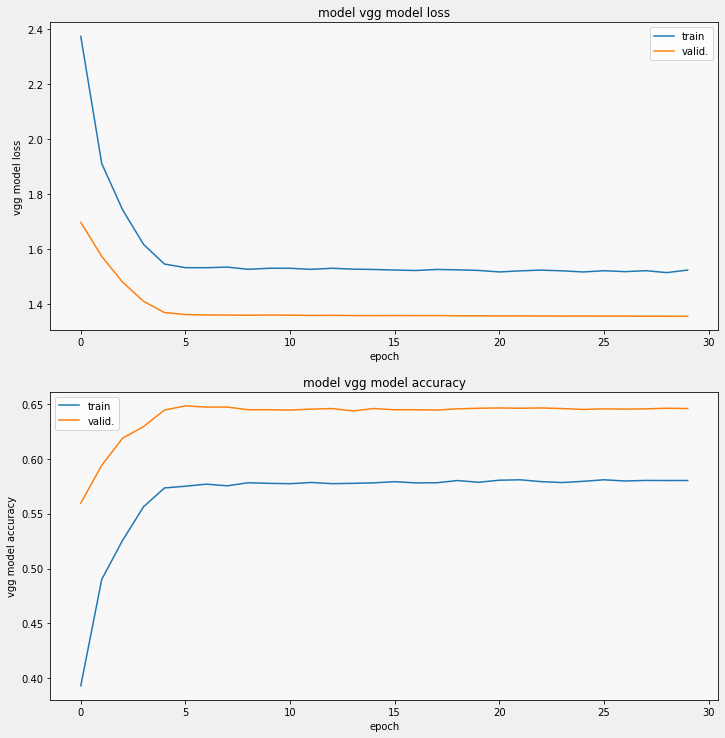

In [25]:
#Training Curves for the vgg model
display_training_curves(
    vgg_history.history['loss'],
    vgg_history.history['val_loss'],
    'vgg model loss',
    211)

display_training_curves(
    vgg_history.history['sparse_categorical_accuracy'],
    vgg_history.history['val_sparse_categorical_accuracy'],
    'vgg model accuracy',
    212)


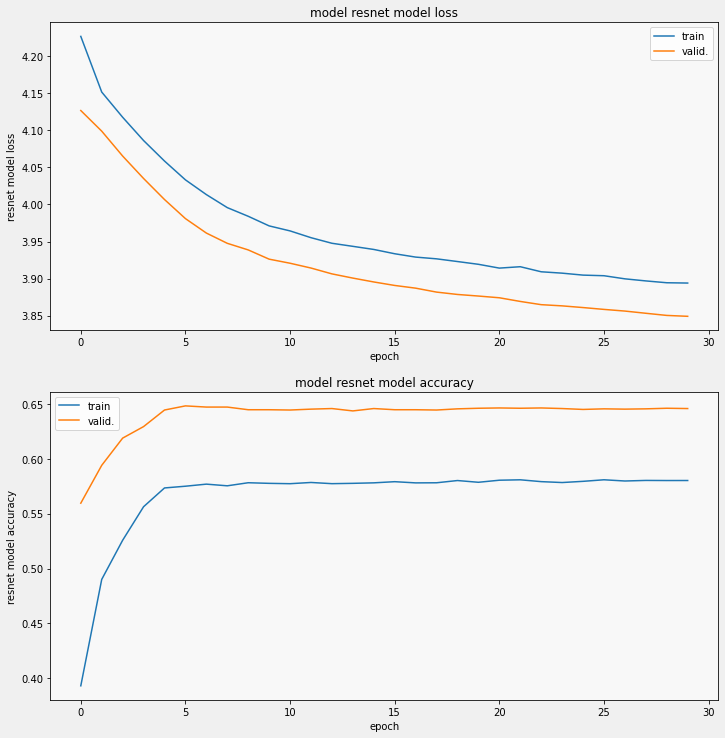

In [26]:
#Training Curves for the resnet 50 model
display_training_curves(
    resnet_history.history['loss'],
    resnet_history.history['val_loss'],
    'resnet model loss',
    211)

display_training_curves(
    vgg_history.history['sparse_categorical_accuracy'],
    vgg_history.history['val_sparse_categorical_accuracy'],
    'resnet model accuracy',
    212)

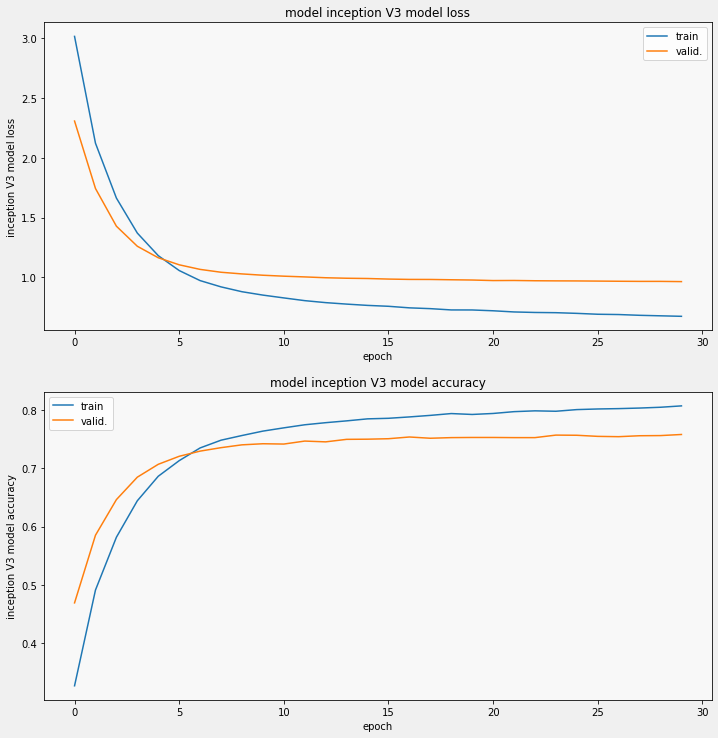

In [27]:
#Training Curves for the inception V3 model
display_training_curves(
    inception_history.history['loss'],
    inception_history.history['val_loss'],
    'inception V3 model loss',
    211)

display_training_curves(
    inception_history.history['sparse_categorical_accuracy'],
    inception_history.history['val_sparse_categorical_accuracy'],
    'inception V3 model accuracy',
    212)


### Confusion Matrix <a name="matrix">


#### VGG <a name="vggmatrix">

In [28]:
cmdataset = get_test_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_TEST_IMAGES))).numpy()
vgg_cm_probabilities = vgg_model.predict(images_ds)
vgg_cm_predictions = np.argmax(vgg_cm_probabilities, axis=-1)

labels = range(len(CLASSES))
vgg_cmat = confusion_matrix(
    cm_correct_labels,
    vgg_cm_predictions,
    labels=labels
)
vgg_cmat = (vgg_cmat.T / vgg_cmat.sum(axis=1)).T # normalize

2022-03-18 14:20:27.350724: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 516415, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647613227.350637108","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 516415, Output num: 0","grpc_status":3}


In [29]:
vgg_cm_predictions
cm_correct_labels[0]


74

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


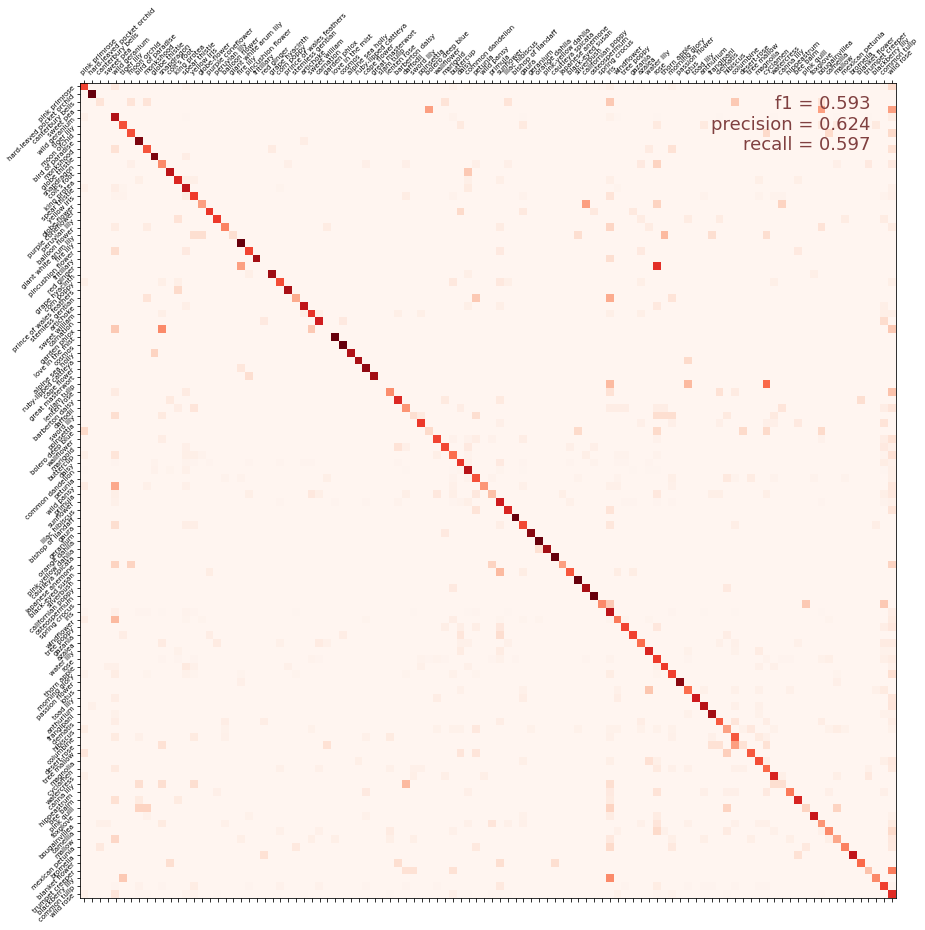

In [30]:
vgg_f1_score = f1_score(
    cm_correct_labels,
    vgg_cm_predictions,
    labels=labels,
    average='macro',
)
vgg_precision = precision_score(
    cm_correct_labels,
    vgg_cm_predictions,
    labels=labels,
    average='macro',
)
vgg_recall = recall_score(
    cm_correct_labels,
    vgg_cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(vgg_cmat, vgg_f1_score, vgg_precision, vgg_recall)

#### Resnet50 <a name="resnetmatrix">

In [31]:
cmdataset = get_test_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_TEST_IMAGES))).numpy()
resnet_cm_probabilities = resnet_model.predict(images_ds)
resnet_cm_predictions = np.argmax(resnet_cm_probabilities, axis=-1)

labels = range(len(CLASSES))
resnet_cmat = confusion_matrix(
    cm_correct_labels,
    resnet_cm_predictions,
    labels=labels,
)
resnet_cmat = (resnet_cmat.T / resnet_cmat.sum(axis=1)).T # normalize

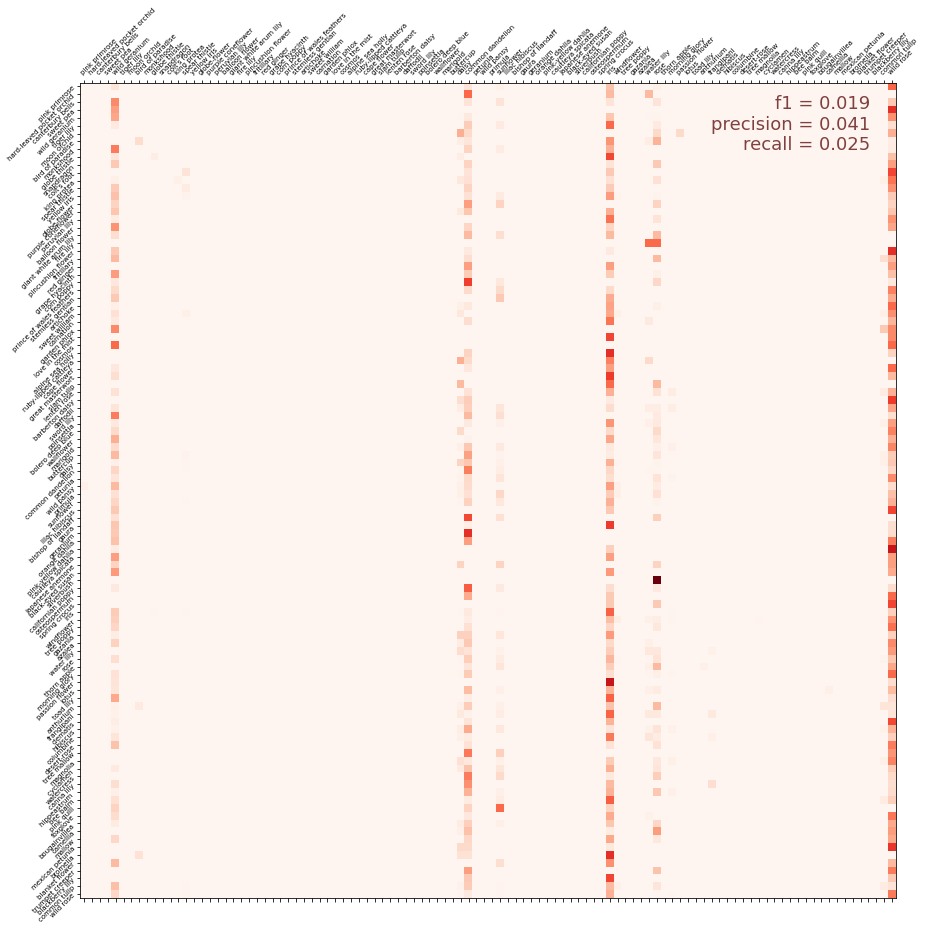

In [32]:
resnet_f1_score = f1_score(
    cm_correct_labels,
    resnet_cm_predictions,
    labels=labels,
    average='macro',
)
resnet_precision = precision_score(
    cm_correct_labels,
    resnet_cm_predictions,
    labels=labels,
    average='macro',
)
resnet_recall = recall_score(
    cm_correct_labels,
    resnet_cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(resnet_cmat, resnet_f1_score, resnet_precision, resnet_recall)

#### InceptionNet V3 <a name="inceptionmatrix">

In [33]:
cmdataset = get_test_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_TEST_IMAGES))).numpy()
inception_cm_probabilities = inception_model.predict(images_ds)
inception_cm_predictions = np.argmax(inception_cm_probabilities, axis=-1)

labels = range(len(CLASSES))
inception_cmat = confusion_matrix(
    cm_correct_labels,
    inception_cm_predictions,
    labels=labels,
)
inception_cmat = (inception_cmat.T / inception_cmat.sum(axis=1)).T # normalize

In [34]:
inception_cmat

array([[0.82716049, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.1       , ..., 0.        , 0.1       ,
        0.1       ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.6969697 ,
        0.        ],
       [0.00487805, 0.        , 0.        , ..., 0.        , 0.00487805,
        0.84390244]])

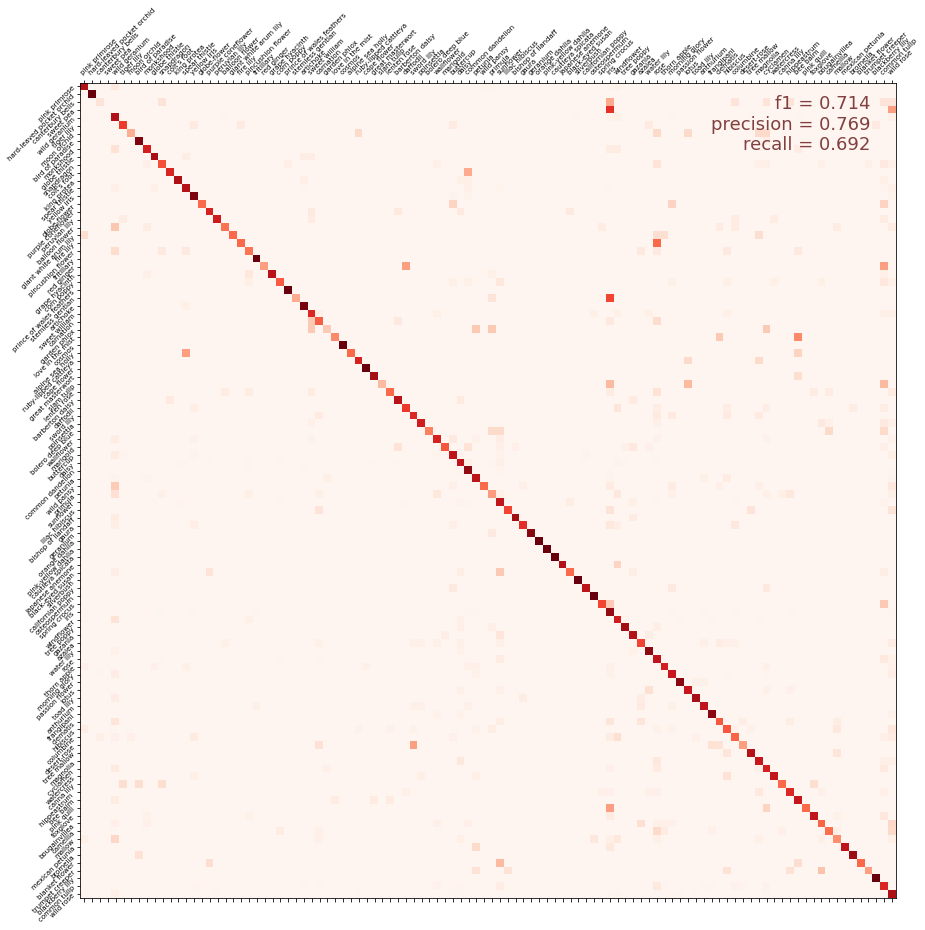

In [35]:
inception_f1_score = f1_score(
    cm_correct_labels,
    inception_cm_predictions,
    labels=labels,
    average='macro',
)
inception_precision = precision_score(
    cm_correct_labels,
    inception_cm_predictions,
    labels=labels,
    average='macro',
)
inception_recall = recall_score(
    cm_correct_labels,
    inception_cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(inception_cmat, inception_f1_score, inception_precision, inception_recall)


## Summary <a name="summary">

    Pretrained networks appear to produce good results even on datasets with classes of very similar objects. Which architecture you choose and the distribution of classes in the data have a great impact on the results.

    Given more time, the results of the flower classifier could have been improved by:
    
* a more balanced distribution of classes. Achieved by collecting more data of the rarer species or by weighting the augmentation process in the preprocessing phase to favor the rarer species.

* a careful selection of hyperparameters could further improve results.

* experimenting with different architectures. 
